In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [4]:
img_paths = []
i = 0
for i in range(int(len(os.listdir('DATA/training/input/'))/2)):
  img_paths.append('DATA/training/input/'+str(i)+'.jpg')
len(img_paths)

1338

In [5]:
img_out_paths = []
i = 0
for i in range(int(len(os.listdir('DATA/training/output/'))/2)):
  img_out_paths.append('DATA/training/output/'+str(i)+'.png')
len(img_out_paths)

1338

In [6]:
def mask_creating(img_path):
  img = cv2.imread(img_path)
  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

  lower_yellow = np.array([25, 50, 180])
  upper_yellow = np.array([35, 255, 255])

  lower_blue = np.array([100, 50, 100]) 
  upper_blue = np.array([140, 255, 255])

  lower_turq = np.array([85, 50, 180])
  upper_turq = np.array([95, 255, 255])

  lower_pink = np.array([145, 50, 180])
  upper_pink = np.array([155, 255, 255])

  mask_yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)/255
  mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)/255
  mask_turq = cv2.inRange(hsv, lower_turq, upper_turq)/255
  mask_pink = cv2.inRange(hsv, lower_pink, upper_pink)/255
  
  masks = np.asarray([mask_yellow, mask_blue, mask_turq, mask_pink])
  masks = np.rollaxis(masks, 0, 3)

  return masks

In [7]:
i = 0
y = []
for i in range(len(img_out_paths)):
  #yellow - 0, blue - 1, turq - 2, pink - 3 
  masks = mask_creating(img_out_paths[i])
  y.append(masks)
  #print(i)
y = np.asarray(y)
np.shape(y)

(1338, 256, 256, 4)

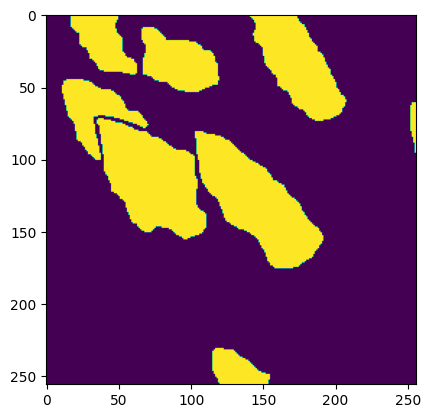

In [8]:
plt.imshow(y[1][:,:, 3])

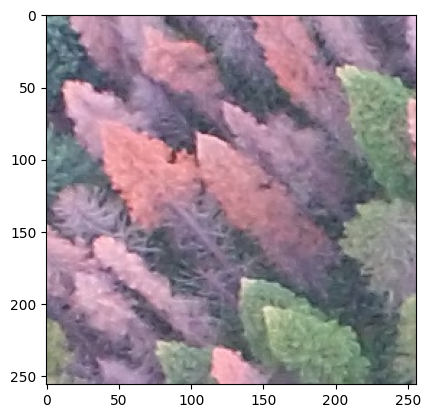

In [9]:
img = cv2.imread('DATA/training/input/1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [10]:
import tensorflow as tf
from tensorflow import keras

In [11]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, 3)
  img = tf.cast(img, tf.float32)
  img = img/255
  return img

In [12]:
dataset = tf.data.Dataset.from_tensor_slices(img_paths)
dataset = dataset.map(load_img)

In [13]:
output_dataset = tf.data.Dataset.from_tensor_slices((y))

In [14]:
dataset_work = tf.data.Dataset.zip((dataset, output_dataset))
dataset_work

<_ZipDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 4), dtype=tf.float64, name=None))>

In [15]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
batch_size = 12
dataset_work = dataset_work.cache().repeat().shuffle(500).batch(batch_size)
dataset_work = dataset_work.prefetch(tf.data.experimental.AUTOTUNE)

In [17]:
test_cnt = int(len(img_paths)*0.2)
train_cnt = int(len(img_paths)*0.8*0.8)
valid_cnt = int(len(img_paths)*0.2*0.8)
print(train_cnt, valid_cnt, test_cnt)
print(train_cnt + valid_cnt + test_cnt)

856 214 267
1337


In [18]:
train_data = dataset_work.take(train_cnt)
test_data = dataset_work.take(test_cnt)
valid_data = dataset_work.take(valid_cnt)

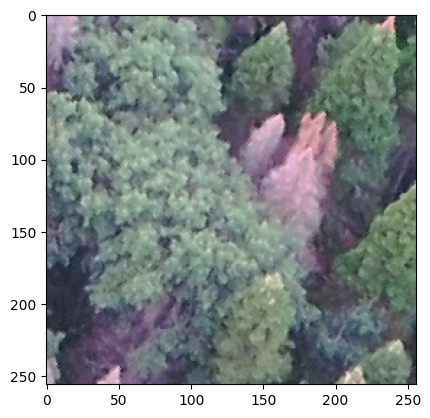

In [19]:
masks = None
for img, masks in train_data.take(1):
  plt.imshow(keras.preprocessing.image.array_to_img(img[0]))
  masks = masks

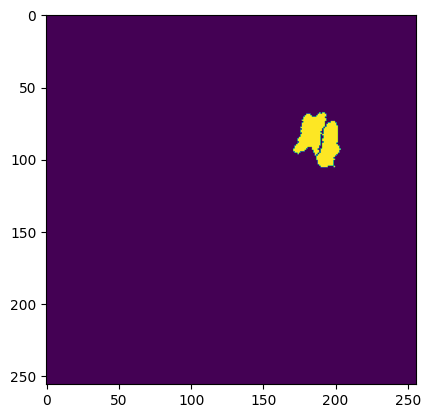

In [20]:
plt.imshow(masks[0][:,:,3])

In [21]:
del y

In [22]:
from tensorflow.keras import layers


def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [23]:
model = get_model((256, 256), 4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [24]:
model.compile(optimizer="Adam", loss="binary_crossentropy", metrics=['categorical_accuracy', tf.keras.metrics.MeanIoU(num_classes=4)])

In [25]:
epochs = 15
hist = model.fit(train_data,
         epochs = epochs,
         validation_data= valid_data,
         )

Epoch 1/15
856/856 [==============================] - 252s 265ms/step - loss: 0.0877 - categorical_accuracy: 0.3840 - mean_io_u: 0.4677 - val_loss: 0.1991 - val_categorical_accuracy: 0.4581 - val_mean_io_u: 0.4660
Epoch 2/15
856/856 [==============================] - 155s 181ms/step - loss: 0.0368 - categorical_accuracy: 0.4569 - mean_io_u: 0.4675 - val_loss: 0.0413 - val_categorical_accuracy: 0.3746 - val_mean_io_u: 0.4659
Epoch 3/15
856/856 [==============================] - 149s 174ms/step - loss: 0.0266 - categorical_accuracy: 0.4534 - mean_io_u: 0.4676 - val_loss: 0.0205 - val_categorical_accuracy: 0.5118 - val_mean_io_u: 0.4658
Epoch 4/15
856/856 [==============================] - 148s 173ms/step - loss: 0.0194 - categorical_accuracy: 0.4538 - mean_io_u: 0.4681 - val_loss: 0.0173 - val_categorical_accuracy: 0.5842 - val_mean_io_u: 0.4664
Epoch 5/15
856/856 [==============================] - 148s 173ms/step - loss: 0.0214 - categorical_accuracy: 0.4544 - mean_io_u: 0.4683 - val_lo

In [26]:
model.save("FinalModel_15ep.h5")

In [7]:
from tensorflow import keras
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


In [10]:
model = keras.models.load_model("FinalModel_15ep.h5")

In [16]:
img = load_img(img_paths[0])
img = np.expand_dims(img, axis=0)
np.shape(img)

(1, 256, 256, 3)

In [17]:
res = model.predict(img)

1/1 [==============================] - 9s 9s/step


In [18]:
np.shape(res)

(1, 256, 256, 4)

In [27]:
from io import BytesIO
from PIL import Image

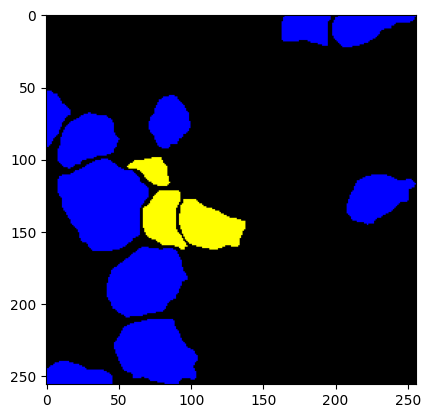

In [29]:
masked_img = Image.open(img_out_paths[0])
plt.imshow(masked_img)

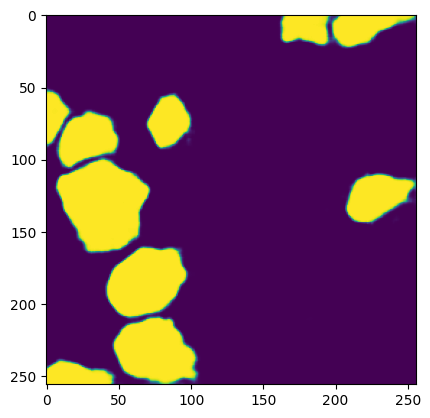

In [30]:
plt.imshow(res[0][:,:,1])

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('FinalModel.tflite', 'wb') as f:
  f.write(tflite_model)